<a href="https://colab.research.google.com/github/YaraAlnaggar/unsupervised-deep-learning_cs294-158_assignments/blob/master/assignment1/HW1_sec2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2 Two-dimensional data
### 2.1 MLP

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from tqdm import trange
% matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

In [0]:
class dataset_sampled_data(torch.utils.data.Dataset):
  def __init__(self, sampled_data, sep = False):
    super(dataset_sampled_data).__init__()
    self.sampled_data = sampled_data
    self.sep = sep
  def __getitem__(self, index):
    if self.sep:
      x1,x2 = self.sampled_data[index]//200, self.sampled_data[index]%200
      return np.array([x1, x2])

    return self.sampled_data[index]
    
  def __len__(self):
    return len(self.sampled_data)

In [0]:
class dataset_sampled_data_hot(torch.utils.data.Dataset):
  def __init__(self, sampled_data,h,w):
    super(dataset_sampled_data).__init__()
    self.sampled_data = sampled_data
    self.w = w
    self.h = h
    self.device = device
  def __getitem__(self, index):
    p  = self.sampled_data[index]
    x1, x2 = p//self.w, p%self.w
    x1_hot,x2_hot = np.zeros((self.h)), np.zeros((self.w))
    x1_hot[x1],x2_hot[x2] = 1,1
    sample = np.concatenate((x1_hot, x2_hot))
    target = np.array([x1,x2])
    return sample, target
    
  def __len__(self):
    return len(self.sampled_data)

In [0]:
def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform(m.weight.data)

In [0]:
joint_prob = np.load("/content/drive/My Drive/unsupervised_assigns/distribution.npy")
two_dim_samples = np.random.choice(np.arange(40000),  p= joint_prob.flatten(), size = 100000)
dataset_sz = len(two_dim_samples)

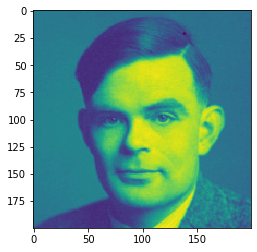

In [8]:
plt.imshow(joint_prob)

In [0]:
# Training settings
batch_sz = 500
test_ratio = 0.2
val_ratio  = 0.2
test_slice = np.floor(dataset_sz*(1-test_ratio)).astype('int')
val_slice = test_slice - np.floor(dataset_sz*val_ratio).astype('int')
steps_per_epoch = np.floor(dataset_sz * 0.6 / batch_sz).astype('int')
eps=1e-8

In [0]:
indices = np.arange(dataset_sz)
test_indices, val_indices, train_indices  = indices[test_slice:] , indices[val_slice : test_slice], indices[:val_slice] 
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [0]:
two_dim_dataset = dataset_sampled_data(two_dim_samples)
train_loader = DataLoader(two_dim_dataset, batch_size= batch_sz, sampler = train_sampler)
val_loader = DataLoader(two_dim_dataset, batch_size= batch_sz, sampler = val_sampler)

## AR model

In [0]:
class AR_model(torch.nn.Module):
    def __init__(self, is_one_hot = False, device = 'cpu'):
        super(AR_model, self).__init__()
        self.is_one_hot = is_one_hot
        self.theta_x1 = torch.nn.Parameter(torch.zeros(200, dtype = torch.float))
        self.model_x2 = torch.nn.Sequential( torch.nn.Linear(200, 200), torch.nn.BatchNorm1d(200), torch.nn.ReLU(), torch.nn.Dropout(p=0.5),
                                             torch.nn.Linear(200, 200), torch.nn.Softmax())
        self.real_num_layer = torch.nn.Sequential( torch.nn.Linear(1, 200),  torch.nn.BatchNorm1d(200), torch.nn.ReLU())
        self.buff_onehot = torch.tensor((batch_sz, 200), dtype = torch.float).to(device)
        self.model_x2.apply(weights_init)

    def forward(self,x1_value):
      self.x1_pred = torch.exp(self.theta_x1) / torch.sum(torch.exp(self.theta_x1))
      # x1_pred_ = self.x1_pred[x1_value.type(torch.long)].view(x1_value.size()[0],1)
      x1_pred_ = torch.gather(self.x1_pred.squeeze(0), 0, x1_value.type(torch.long)).unsqueeze(1)
      if self.is_one_hot:
        self.buff_onehot.resize_(x1_value.size()[0], 200).zero_()
        self.buff_onehot.scatter_(1, x1_value.unsqueeze(1), 1)
        # x2_input = self.one_hot_layer(self.buff_onehot)
        x2_input = self.buff_onehot
      else:
        x2_input = self.real_num_layer(x1_value.view(-1,1))
      x2_on_x1_pred = self.model_x2(x2_input)
      out_log = torch.log2(x2_on_x1_pred+eps) + torch.log2(x1_pred_+eps).repeat(1, 200)
      return out_log
    

### real number input

In [13]:
torch.cuda.empty_cache()
model = AR_model(device = device).to(device)
criterion = torch.nn.NLLLoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
# trainign loop
train_loss,val_loss = [],[]
for epoch in range(10):
  minibatch_loss = 0
  for i, index in enumerate(train_loader, 0):
    optimizer.zero_grad()
    x1_index = index // 200    
    x2_index = index % 200
    log_pred = model.forward(x1_index.float().to(device))
    loss = criterion(log_pred, x2_index.cuda())
    loss.backward()
    optimizer.step()
    minibatch_loss += loss.item()
  epoch_train_loss = minibatch_loss/i 
  train_loss.append(epoch_train_loss)
  print("epoch {}  training loss: {}".format(epoch, epoch_train_loss))

  # validation cycle
  val_cum_loss = 0
  for val_samples in val_loader:
    x1_index = index // 200    
    x2_index = index % 200
    log_pred = model.forward(x1_index.float().to(device))
    loss = criterion(log_pred, x2_index.cuda())
    val_cum_loss += loss.item()
  epoch_val_loss = val_cum_loss/len(val_loader)
  val_loss.append(epoch_val_loss)
  print("epoch {} val loss: {} ".format(epoch,epoch_val_loss))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch 0  training loss: 15.642893486664075
epoch 0 val loss: 15.38655002117157 
epoch 1  training loss: 15.49713908924776
epoch 1 val loss: 15.333987545967101 
epoch 2  training loss: 15.445855020474987
epoch 2 val loss: 15.270844292640685 
epoch 3  training loss: 15.414231757155987
epoch 3 val loss: 15.28884961605072 
epoch 4  training loss: 15.389899975111504
epoch 4 val loss: 15.262680530548096 
epoch 5  training loss: 15.374512952916762
epoch 5 val loss: 15.269588112831116 
epoch 6  training loss: 15.362915423737855
epoch 6 val loss: 15.237536907196045 
epoch 7  training loss: 15.35538033076695
epoch 7 val loss: 15.270794034004211 
epoch 8  training loss: 15.349001812333821
epoch 8 val loss: 15.209992718696594 
epoch 9  training loss: 15.345060084046436
epoch 9 val loss: 15.242096138000488 


Text(0.5, 1.0, 'negative log likelihood')

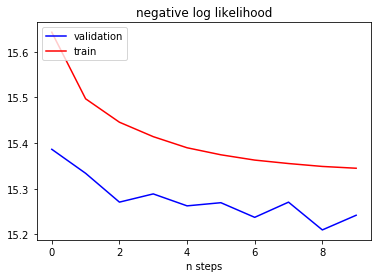

In [15]:
plt.plot(val_loss, '-b', label = 'validation')
plt.plot(train_loss, '-r', label = 'train')
plt.xlabel('n steps')
plt.legend(loc='upper left')
plt.title("negative log likelihood")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


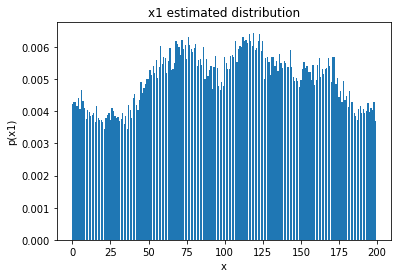

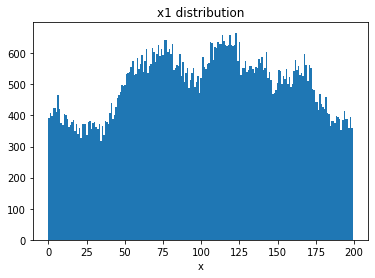

In [16]:
plt.bar(np.arange(200), torch.nn.functional.softmax(model.theta_x1).cpu().detach().numpy() )
plt.title('x1 estimated distribution')
plt.xlabel('x')
plt.ylabel('p(x1)')
plt.show()
plt.hist(two_dim_samples//200 , bins=200)
plt.title('x1 distribution')
plt.xlabel('x')
plt.show()

In [17]:
# sampling from 2D distribution
input_x1 =  torch.from_numpy(np.arange(200)).float().to(device)
# model denisity function
model.eval()
output_x1_joint_x2 = model.forward(input_x1).cpu().detach().numpy()
sampeled_values = np.random.choice(np.arange(40000),size = 1000000, p = 2**output_x1_joint_x2.flatten() ).T
x1_index = sampeled_values // 200 # rows
x2_index = sampeled_values % 200 #columns

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


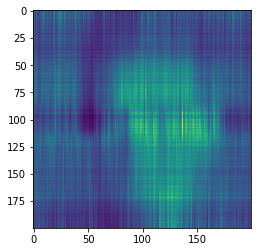

In [18]:
draw = 2 ** output_x1_joint_x2
plt.imshow(draw.reshape(200,200))
plt.grid(False)

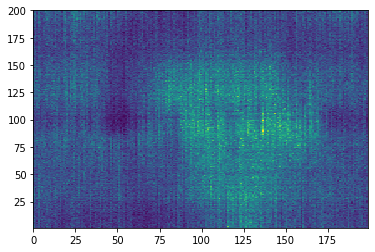

In [19]:
h = plt.hist2d(x2_index, 200-x1_index, bins=200)
plt.show()

### One-hot vector as x1 input

In [20]:
torch.cuda.empty_cache()
model_one_hot_vec = AR_model(is_one_hot=True, device= device).to(device)

criterion = torch.nn.NLLLoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model_one_hot_vec.parameters())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
# trainign loop
train_loss,val_loss = [],[]
for epoch in range(10):
  minibatch_loss = 0
  for i, index in enumerate(train_loader, 0):
    optimizer.zero_grad()
    x1_index = index // 200     
    x2_index = index % 200
    log_pred = model_one_hot_vec.forward(x1_index.long().to(device))
    loss = criterion(log_pred, x2_index.cuda())
    loss.backward()
    optimizer.step()
    minibatch_loss += loss.item()
    # print("epoch {} in step {}".format(epoch,i))

  epoch_train_loss = minibatch_loss/i 
  train_loss.append(epoch_train_loss)
  print("epoch {}  training loss: {}".format(epoch, epoch_train_loss))
  # validation cycle
  val_cum_loss = 0
  for val_samples in val_loader:
    val_x1 = val_samples // 200
    val_x2 = val_samples % 200
    log_pred = model_one_hot_vec.forward(val_x1.long().to(device))
    loss = criterion(log_pred.to(device), val_x2.to(device))
    val_cum_loss += loss.item()
  epoch_val_loss = val_cum_loss/len(val_loader)
  val_loss.append(epoch_val_loss)
  print("epoch {} val loss: {} ".format(epoch,epoch_val_loss))

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch 0  training loss: 15.752095591120359
epoch 0 val loss: 15.459459352493287 
epoch 1  training loss: 15.472332585759524
epoch 1 val loss: 15.35455265045166 
epoch 2  training loss: 15.372938460662585
epoch 2 val loss: 15.325248432159423 
epoch 3  training loss: 15.326827922788988
epoch 3 val loss: 15.307151651382446 
epoch 4  training loss: 15.290484420391692
epoch 4 val loss: 15.301481199264526 
epoch 5  training loss: 15.267525192068405
epoch 5 val loss: 15.296785402297974 
epoch 6  training loss: 15.245587485177177
epoch 6 val loss: 15.300899720191955 
epoch 7  training loss: 15.230884944691377
epoch 7 val loss: 15.307316541671753 
epoch 8  training loss: 15.219691669239717
epoch 8 val loss: 15.319022631645202 
epoch 9  training loss: 15.2086174988947
epoch 9 val loss: 15.326633405685424 


Text(0.5, 1.0, 'negative log likelihood')

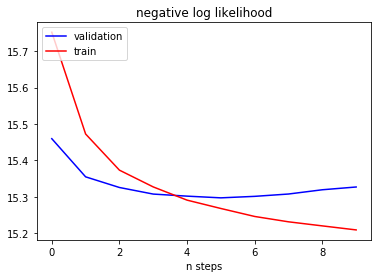

In [22]:
plt.plot(val_loss, '-b', label = 'validation')
plt.plot(train_loss, '-r', label = 'train')
plt.xlabel('n steps')
plt.legend(loc='upper left')
plt.title("negative log likelihood")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


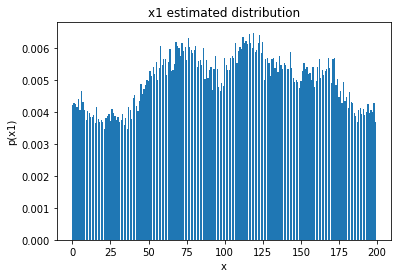

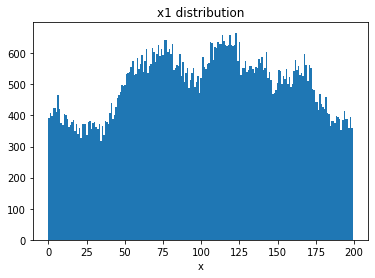

In [23]:
plt.bar(np.arange(200), torch.nn.functional.softmax(model_one_hot_vec.theta_x1).cpu().detach().numpy() )
plt.title('x1 estimated distribution')
plt.xlabel('x')
plt.ylabel('p(x1)')
plt.show()
plt.hist(two_dim_samples//200 , bins=200)
plt.title('x1 distribution')
plt.xlabel('x')
plt.show()

In [24]:
# sampling from 2D distribution
input_x1 =  torch.from_numpy(np.arange(200)).to(device).type(torch.cuda.LongTensor)
# model denisity function
model_one_hot_vec.eval()
output_x1_joint_x2 = model_one_hot_vec.forward(input_x1).cpu().detach().numpy()
sampeled_values = np.random.choice(np.arange(40000),size = 1000000, p = 2**output_x1_joint_x2.flatten() ).T
x1_index = sampeled_values // 200 # rows
x2_index = sampeled_values % 200 #columns

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


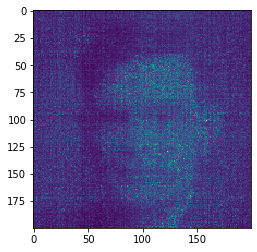

In [25]:
draw = 2 ** output_x1_joint_x2
plt.imshow(draw.reshape(200,200))
plt.grid(False)

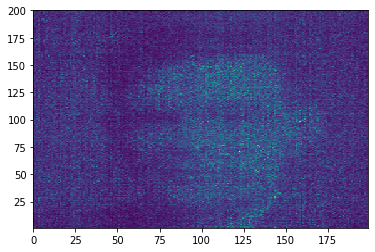

In [26]:
h = plt.hist2d(x2_index, 200-x1_index, bins=200)
plt.show()

## MADE

### Made Body

In [0]:
class MADE(torch.nn.Module):
  def __init__(self, dim_num, dim_sz, num_hidden_layers, hidden_layers_sz, num_masks, num_orderings, device= "cpu" ):
    super(MADE,self).__init__()
    self.num_hidden_layers = num_hidden_layers
    self.num_masks = num_masks
    self.p = num_orderings
    self.dim_num = dim_num
    self.dim_sz = dim_sz
    self.hidden_layers_sz = hidden_layers_sz
    self.model = torch.nn.Sequential()
    self.create_model()
    weights_init(self.model)
    self.input_order = []
    self.masks_order = []
    self.init_masks()
    self.mask = []
    self.device = device
    print(self.device)
    
  def create_model(self):
    self.model.add_module("input", torch.nn.Linear(self.dim_num, self.hidden_layers_sz[0]) )
    self.model.add_module("activ_0", torch.nn.ReLU())
    for i, layer in enumerate( range(1,self.num_hidden_layers), 0):
      self.model.add_module("hidden_"+ str(i), torch.nn.Linear(self.hidden_layers_sz[i], self.hidden_layers_sz[i+1]))
      self.model.add_module("activ_"+ str(i), torch.nn.ReLU())
    self.model.add_module("output", torch.nn.Linear(self.hidden_layers_sz[-1], self.dim_sz*self.dim_num))

    # initialize model weights
    self.model.apply(weights_init)
    
#Todo support Order-agnostic training
  def init_masks(self):
    self.input_order = np.arange(0,self.dim_num)
    for mask in range(self.num_masks):
      mask_layers = [self.input_order]
      for i in range(self.num_hidden_layers):
        m_layer = np.random.choice(range(0,self.dim_num-1), size = self.hidden_layers_sz[i], replace = True)
        mask_layers.append(m_layer)
      output_order = np.repeat(self.input_order,self.dim_sz)
      mask_layers.append(output_order)
      self.masks_order.append(mask_layers)

  def create_masks(self, mask_index):
    m_mask = self.masks_order[mask_index]
    for i in range(1,self.num_hidden_layers+1):
      mask_layer = m_mask[i].reshape(-1,1)  >=   m_mask[i-1].reshape(1,-1) 
      self.mask.append(torch.from_numpy(mask_layer).float().to(device))
    mask_out = m_mask[-1].reshape(-1,1) > m_mask[-2].reshape(1,-1)
    self.mask.append(torch.from_numpy(mask_out).float().to(device))
    # print("created mask", self.mask)

  def apply_masks(self):
    s = 0
    for name, param in self.model.named_parameters():
      if 'weight' in name:
        param.data.mul_(self.mask[s])
        s+=1

  def forward(self, input):
    self.mask = []
    mask_index = np.random.randint(self.num_masks)
    self.create_masks(mask_index)
    self.apply_masks()
    output = self.model(input)
    return output

### run MADE

In [33]:
model =   MADE(dim_num = 2 ,dim_sz = 200,  num_hidden_layers= 1, hidden_layers_sz = [600], num_masks = 1, num_orderings = 0, device = device ).to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss().to(device)

cuda:0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
# two_dim_dataset_hot = dataset_sampled_data_hot(two_dim_samples,h= 200, w=200)
two_dim_dataset = dataset_sampled_data(two_dim_samples,sep=True)
train_loader = DataLoader(two_dim_dataset, batch_size= 100, sampler = train_sampler)
val_loader = DataLoader(two_dim_dataset, batch_size= 100, sampler = val_sampler)

In [35]:
train_loss = []
val_loss = []
step = 0
for e in range(10):
  minibatch_loss = 0
  for i,input_tensor in enumerate(train_loader,0):
    optimizer.zero_grad()
    pred = model.forward(input_tensor.float().to(device))
    loss = criterion(pred.view(-1,2,200).permute(0,2,1),input_tensor.to(device))
    minibatch_loss += loss.item()
    loss.backward()
    optimizer.step()

  epoch_train_loss = minibatch_loss/i 
  train_loss.append(epoch_train_loss)
  print("epoch {}  training loss: {}".format(e, epoch_train_loss))
  epoch_val_loss = 0
  for i,input_tensor in enumerate(val_loader,0):
    pred = model.forward(input_tensor.float().to(device))
    batch_loss =  criterion(pred.view(-1,2,200).permute(0,2,1),input_tensor.to(device))
    epoch_val_loss += batch_loss.item()
  print("epoch val loss ", epoch_val_loss/i)
  val_loss.append(epoch_val_loss/i)

epoch 0  training loss: 5.4620513748844
epoch val loss  5.355083300240675
epoch 1  training loss: 5.305908036749431
epoch val loss  5.312490988017327
epoch 2  training loss: 5.28746232365527
epoch val loss  5.306389667280954
epoch 3  training loss: 5.283833053155813
epoch val loss  5.305809267801256
epoch 4  training loss: 5.281987002377518
epoch val loss  5.305212341960351
epoch 5  training loss: 5.2811302780508
epoch val loss  5.304824517599902
epoch 6  training loss: 5.280343249166549
epoch val loss  5.305801990643219
epoch 7  training loss: 5.2798169212468675
epoch val loss  5.304968335520682
epoch 8  training loss: 5.279306723796863
epoch val loss  5.307499375175591
epoch 9  training loss: 5.278845128710561
epoch val loss  5.306477673688725


Text(0.5, 1.0, 'negative log likelihood')

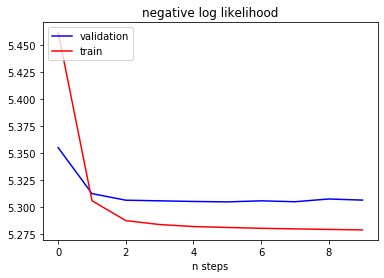

In [36]:
plt.plot(val_loss, '-b', label = 'validation')
plt.plot(train_loss, '-r', label = 'train')
plt.xlabel('n steps')
plt.legend(loc='upper left')
plt.title("negative log likelihood")

In [0]:
two_dim_sample = dataset_sampled_data(torch.from_numpy(np.arange(200*200)),sep=True)
sample_loader = DataLoader(two_dim_sample, batch_size= 200*200)
input = next(iter(sample_loader))
input_hot = np.zeros((input.shape[0],400))
input_hot[np.arange(input.shape[0]),input[:,0].numpy()] = 1
input_hot[np.arange(input.shape[0]),input[:,1].numpy()+200] = 1

In [0]:
# sampling from 2D distribution
input = next(iter(sample_loader))
# model denisity function
model.eval()
output = model.forward(input.float().to(device))
prob = torch.log2(torch.nn.functional.softmax(output.view(-1,2,200).permute(0,2,1), dim=1).permute(0,2,1).reshape(-1,400))
prob_ = torch.sum(prob[input_hot!=0].view(-1,2),1).cpu().detach().numpy().reshape(200,200)
sampeled_values = np.random.choice(np.arange(40000),size = 1000000, p = 2**prob_.flatten()).T

x1_index = sampeled_values // 200 # rows
x2_index = sampeled_values % 200 #columns

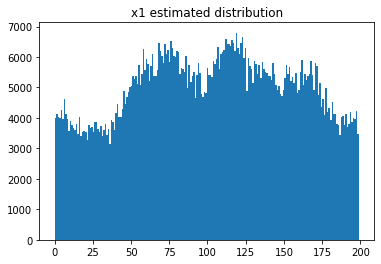

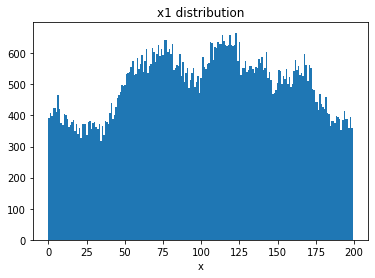

In [39]:
plt.hist(x1_index , bins=200)
plt.title('x1 estimated distribution')
plt.show()
plt.hist(two_dim_samples//200 , bins=200)
plt.title('x1 distribution')
plt.xlabel('x')
plt.show()

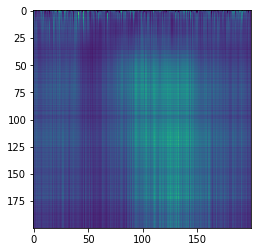

In [40]:
plt.imshow(2**prob_)
plt.grid(False)

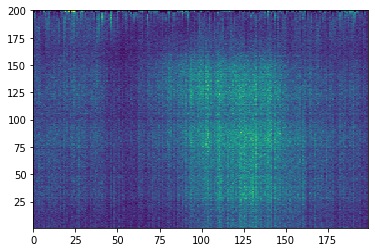

In [41]:
h = plt.hist2d(x2_index, 200-x1_index, bins=200)
plt.show()